In [1]:
### imports

### DEV
from samcc_turbo import wrappers, socket_parser, socketClass, helper_functions, bundleClass
import importlib
importlib.reload(wrappers)
importlib.reload(socket_parser)
importlib.reload(socketClass)
importlib.reload(bundleClass)
importlib.reload(helper_functions)

### END-DEV

import pickle
import sys
from samcc_turbo.wrappers import run_dssp
from samcc_turbo.wrappers import run_socket
from samcc_turbo.socket_parser import parse_socket_output
from samcc_turbo.socketClass import socket_class
from samcc_turbo.bundleClass import bundleClass

bin_paths = {'dssp':'dssp', 'socket':'/home/kszczepaniak/Apps/socket3.03/socket'}

In [2]:
def run_samcc_turbo(pdbpath, mode='auto-detect', deffile=None, defdata=None,
                    plot=True, save_df=True, save_pse=True,
                    bin_paths={'dssp':'dssp', 'socket':'socket'},
                    layer_detect_n=5, max_dist=50, search_set_n=3):
    """Main function for running samcc-turbo.

    Arguments (general):
    pdbpath   -- path to pdb file (.pdb)
    mode      -- mode of running SamCC (default 'auto-detect')
               - auto-detect: automatic detection of layers in the bundle (requires
                              installed dssp and Socket)
               - defdata: use layer definition from list
               - deffile: use layer definition from file
    deffile   -- path to file defining layers used in deffile mode (default None)
    plot      -- plot results and also save plot to file (default True)
    save_df   -- save result DataFrame to pickle (default True)
    save_pse  -- save pymol session with drawn layers (default True)
    bin_paths -- dictionary of paths to binaries of dssp and socket
                 (default {'dssp': 'dssp', 'socket':'socket'})

    Arguments (auto-detect mode specific):
    layer_detect_n -- number of residues from each helix that will be combined
                      into layers that will be considered in layer detection
                      (default 5)
    max_dist       -- distance threshold [A] that will be used to indicate unusual
                      layer setting; if total distance between residues in layer
                      if greater that this number the layer will be discarded, if
                      no layer will pass this filter then layer detection will
                      be repeated with bigger layer_detect_n (default 50)
    search_set_n   -- number of starting layer settings that will be selected
                      basing on minimal distance between residues to be compared
                      in terms of angle between all layers in structure (default 3)
    Arguments (defdata mode specific):
    defdata   -- list of parameters defining layer setting (default None)
    """

    ###DEV-TXT: minimalne użycie: mierzaczka(pdb) odpala dssp, socket, parsuje socket, mierzy, zwraca df, wykres i sesje pymol
    ###DEV-TXT: wersja 0.1A: użycie pliku definiującego helisy (stare samcc)
    ###DEV-TXT: wersja 0.2: kontrola parametrów: czy wykres, df, pymol, ścieżki
    ###DEV-TXT: v. 0.3: defdata mode, expert notebook  and most socketClass annotated with fixme
    ###DEV-TXT: v. 0.4: all fixes annotated

    ###DEV-TXT: wersja podająca bezpośrednio definicję (bez pliku)

    # get pdbid
    pdbid = pdbpath.split('/')[-1].split('.')[0]

    if mode == 'auto-detect':
        # run dssp and socket ('auto-detect' mode)
        dssppath       = run_dssp(pdbpath, bin_paths['dssp'])
        socketpath     = run_socket(pdbpath, dssppath, bin_paths['socket'])
        socket_data    = parse_socket_output(socketpath)
        s 			   = socket_class(socket_data, pdbpath)

        bundles = s.get_bundles(mode=mode, res_num_layer_detection=layer_detect_n,
                                distance_threshold=max_dist,
                                search_layer_setting_num=search_set_n)

        for bid, bundle in enumerate(bundles):
            bundle.calc_bundleaxis()
            bundle.calc_periodicity()
            bundle.calc_radius()
            bundle.calc_crick()
            bundle.calc_crickdev(3.5, 7, optimal_ph1=19.5)
            bundle.calc_axialshift()
            if plot: # make plot and save it to file
                bundle.plot(pdbid + '.png', elements=['Periodicity', 'Radius', 'CrickDev', 'Shift'])

            if save_df: # dump pickle with dataframe of measured values
                pickle.dump(bundle.gendf(), open(pdbpath.split('.')[0] + '_coil_' + str(bid) + '.p', 'wb'))

            #FIXME bundle_axis parameter is temporary unless accepted as production feature
            #FIXME is it necessarry to give bundle atributes here?
            if save_pse:
                bundle.pymol_plot_layer(filename=pdbpath ,savepath='/'.join(pdbpath.split('/')[:-1]), suffix='coil_' + str(bid),
                                        pymol_version=2.0, color_selection=True, helix_order=bundle.helix_order)

    elif mode == 'defdata':

        bundle = bundleClass()
        bundle.from_defdata(pdbpath, *defdata)

        bundle.calc_bundleaxis()
        bundle.calc_periodicity()
        bundle.calc_radius()
        bundle.calc_crick()
        bundle.calc_crickdev(3.5, 7, optimal_ph1=19.5)
        bundle.calc_axialshift()

        if plot: # make plot and save it to file
            bundle.plot(pdbid + '.png', elements=['Periodicity', 'Radius', 'CrickDev', 'Shift'])

        if save_df: # dump pickle with dataframe of measured values
            pickle.dump(bundle.gendf(), open(pdbpath.split('.')[0] + '_coil.p', 'wb'))

        if save_pse:
            bundle.pymol_plot_layer(filename=pdbpath ,savepath='/'.join(pdbpath.split('/')[:-1]), suffix='coil',
                                    pymol_version=2.0, color_selection=True, helix_order=bundle.helix_order)

Saving pymol session with layers...
1qx8 saved.


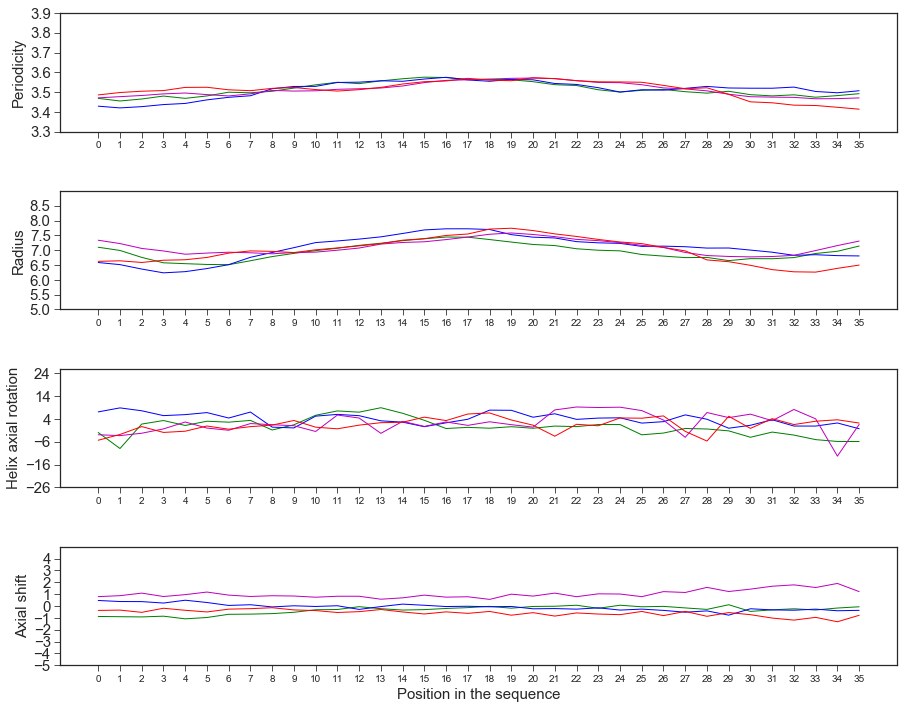

In [3]:
run_samcc_turbo('1qx8.pdb1', bin_paths=bin_paths)

Saving pymol session with layers...
1qx8 saved.


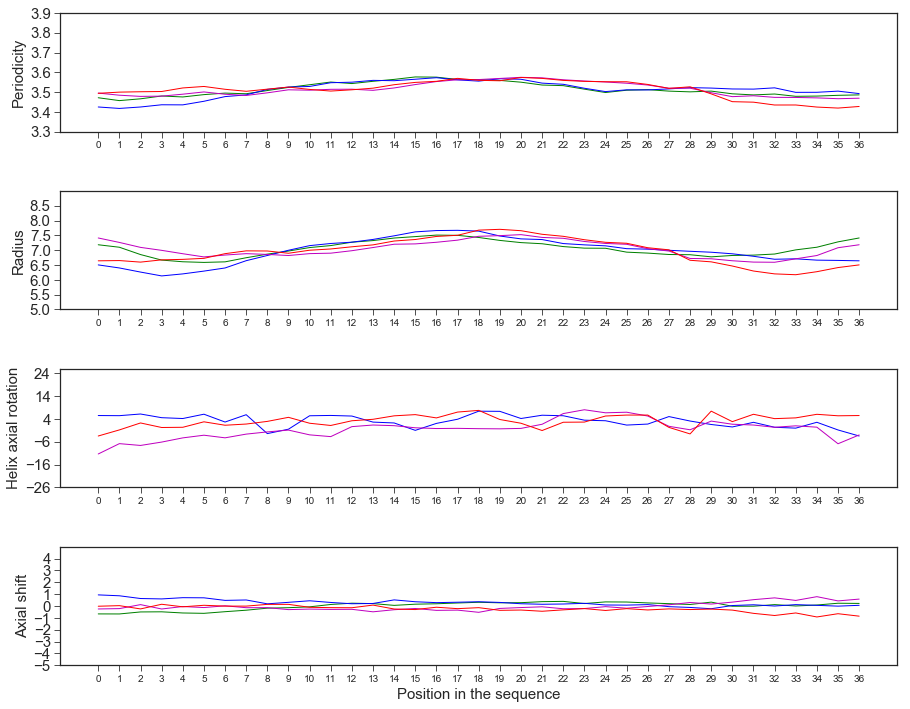

In [16]:
defdata = [[range(8, 47), range(8, 47), range(8,47)[::-1], range(8,47)[::-1]],
           ['A', 'B', 'C', 'D'],
           [False, False, True, True],
           ['e', 'd', 'g', 'g']]

run_samcc_turbo('1qx8.pdb1', mode='defdata', defdata=defdata)